# Extracting Representations from the layers of a Deep Neural Networks




One of the most basic and useful operations on a deep network is the extraction
of representations from its hidden layers, in order to make sense of its operations.
This is an operation analogous to the recording of the activty of neurons in cortical
areas.



Representations are in themselves remarkable objects of
investigation. 

What can we do with representations ? Here are a couple of examples from the 
contents presented in this School :

- Representations are the encoding of the data at a given layer, and their categorical
content can be decoded from there. So we can decode the categorical information 
and other latent information (if available) such as luminance, orientation, shape features.
We will focus more on categorical information here : the performance of this decoding, which is 
typically done with a linear classifier like a support vector machine (SVM) tells
us how explicitly the categorical information is contained in the representation.


- Measure the mutual information between the input and the representation $T$ at a certain
hidden layer and the mutual information between $T$ and the ground truth labels Y, like 
in the Information Bottleneck approach presented by Tishby.


- Using the features for Transfer Learning like we did in the hands-on session on convolutional
networks

But there are many others. A modern application is this for example :

- Monitoring the approach of a network during the training to its *final* state, like in the 
SVCCA approach described here : https://arxiv.org/abs/1706.05806. This approach offered
novel insights on how do the hidden layers differentially converge during the training and on how
distributed is the representation of information in deep networks.


The only limit is your scientific curiosity.
 
 

In this hands-on session we will 

- see how to extract representations from hidden layers of a deep network in Keras
- we will take a look at how do these representations evolve along the hidden layers with the Representation Similarity Matrix tecnique 
- we will try to decode the categorical content from these representations with linear classifiers (SVM).
This operation will require the search of the best model parameter (C) in a cross-validated way (as we saw in the
hands-on tutorial on Overfitting and Regularization)

In [1]:
# imports

import os
import os.path as path
from os import listdir 
from os.path import isfile, join
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import h5py

from keras.datasets import mnist
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


# Load data

We load a sample of data to work with. We will sample it from the test set.

In [2]:
(i_train, l_train), (i_test, l_test) = mnist.load_data()
i_train, i_test = i_train/255.0, i_test/255.0
i_train, i_test = i_train.astype(np.float32), i_test.astype(np.float32)
i_train, i_test = np.expand_dims(i_train, 3), np.expand_dims(i_test, 3)
l_test_int = l_test # keep labels in integer form
l_train, l_test = to_categorical(l_train), to_categorical(l_test)

In [3]:
# extract a random sample of n_sample elements from each category in test set

n_samples = 10
samples = np.zeros((n_samples*10,28,28,1))
labels = np.zeros((n_samples*10,))
labels_int = []
for i in range(10):
    labels_int.append([i]*n_samples)
    mask = l_test_int == i
    temp_i_test = i_test[mask]
    idx = np.random.permutation(temp_i_test.shape[0])[:n_samples]
    samples[i*n_samples: (i+1)*n_samples,:,:,:] = temp_i_test[idx]
    labels[i*n_samples: (i+1)*n_samples] = np.zeros((n_samples,)) + i
labels = to_categorical(labels)
labels_int = np.asarray(labels_int).flatten()

In [4]:
print(samples.shape)
print(labels.shape)

(100, 28, 28, 1)
(100, 10)


# Load pre-trained model

We load a pre-trained multi-layer perceptron (MLP) with 3 hidden layers

In [5]:
model = load_model(join('models', 'mlp3.h5'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
images (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
hidden1 (Dense)              (None, 100)               78500     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
hidden3 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 10)                1010      
Total params: 99,710
Trainable params: 99,710
Non-trainable params: 0
_________________________________________________________________
None


# Extraction

In order to extract representations Keras has an elegant solution.
Look at the following thread in stackoverflow for the relative discussion :
https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer




In [6]:
def extract_representations(model):
    inp = model.input                                           # input placeholder
    outputs = [layer.output for layer in model.layers]          # all layer outputs
    functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function
    layer_outs = functor([samples, 1.])
    return layer_outs

In [7]:
layer_outs = extract_representations(model)

In [8]:
# check that the output shapes are correct, let'use list comprehension 
_ = [print(l.name, lo.shape) for l,lo in zip(model.layers, layer_outs)]

images (100, 28, 28, 1)
flatten_1 (100, 784)
hidden1 (100, 100)
hidden2 (100, 100)
hidden3 (100, 100)
output (100, 10)


Now we have representations and should figure out what to do with these numbers.
What is your proposal ?

The idea is to look at how similar look the data of each category across the layers.
What we expect is that the images that belong to the same category come closer and closer
and images that belong to different categories are progressively segregated.

# Representation Similarity Analysis

This analysis and its broad applications in Neuroscience are described here :

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2605405/

and a toolbox to perform refined analysis are here : 

https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003553


Here we refer to artificial neural networks but the conceptual framework is the same.

<img src="figs/RSA.png" alt="drawing" width="300" >



We will simply compute distances between the representations (also the input) of all
the pairs $(x_i,x_j)$ of different images and see how they evolve across layers

These distances form the Representation Similarity Matrix :


$RSM^{(l)}(x_i,x_j) = d^{(l)}(x_i,x_j)$

where $l$ is the layer and $d$ is the euclidean distance.

In [9]:
from scipy.spatial.distance import pdist, squareform

In [10]:
def getRSM(layer_outs):
    dists = [squareform(pdist(l.reshape(l.shape[0],-1),'euclidean')) for l in layer_outs]
    ndists = [1 - dist/np.max(dist) for dist in dists]
    return ndists

In [11]:
ndists = getRSM(layer_outs)
names  = [l.name for l in model.layers]
_ = [print(ndist.shape) for ndist in ndists]

(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


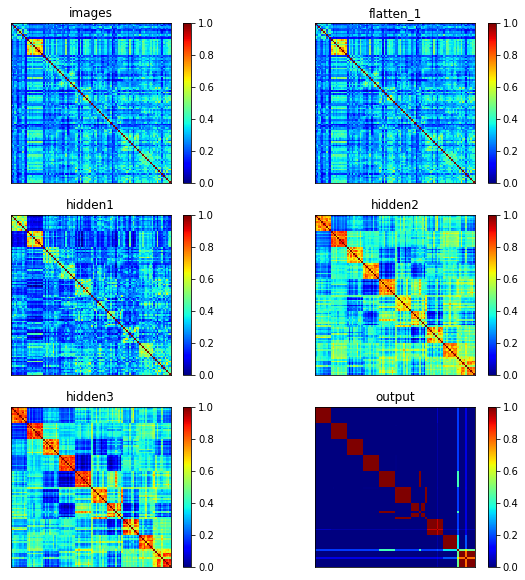

In [12]:
fig = plt.figure(figsize=(10,10))
for i, (name, ndist) in enumerate(zip(names, ndists)):    
    plt.subplot(3,2,i+1)        
    plt.imshow(ndist, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.title(name)
    plt.colorbar()
plt.show()

Question : Do you notice something strange in RSM of the output layer ? What are those thin strips ? 

Proposed exercise : Try to figure out what is the reason behind this behavior and provide a proof by looking at explicit examples from the images involved.

# Convolutional

Let us do the same with a convolutional network. We use one with 2 convolutional layers.
We will have to modify our function for the RSM computation along the way.


``
img = layers.Input(shape=(28,28,1,))
x = layers.Conv2D(20, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(40, 5, activation=activation_fcn)(img)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation=activation_fcn)(x)
out = layers.Dense(10, activation='softmax')(x)
``

In [13]:
model = load_model(join('models', 'convolutional_2layers.h5'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 40)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 40)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               576100    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 578,150
Trainable params: 578,150
Non-trainable params: 0
_________________________________________________________________
None

In [14]:
layer_outs = extract_representations(model)
names  = [l.name for l in model.layers]
_ = [print(name, l.shape) for name,l in zip(names,layer_outs)]

input_1 (100, 28, 28, 1)
conv2d_2 (100, 24, 24, 40)
max_pooling2d_2 (100, 12, 12, 40)
flatten_1 (100, 5760)
dense_1 (100, 100)
dense_2 (100, 10)


In [15]:
ndists = getRSM(layer_outs)

# Differences between the representations at different layers

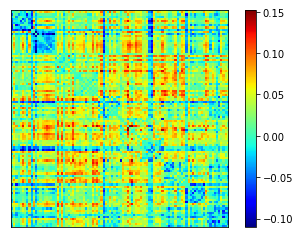

In [16]:
d = ndists[0] - ndists[2]
plt.imshow(d, cmap='jet')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

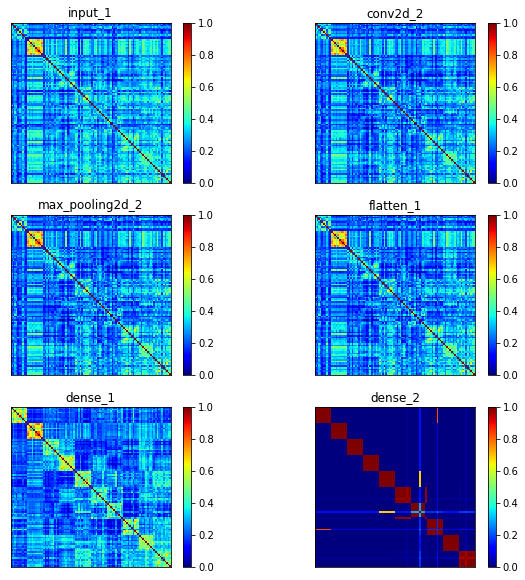

In [17]:
fig = plt.figure(figsize=(10,10))
for i, (name, ndist) in enumerate(zip(names, ndists)):    
    plt.subplot(3,2,i+1)        
    plt.imshow(ndist, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.title(name)
    plt.colorbar()
plt.show()

# Decoding Representations in Deep Networks


Delineate decoding approach (Poggio 1995)
http://science.sciencemag.org/content/310/5749/863

Attach to the lecture


Identity of the methodology with networks (we do this here)

SVM + Cross val


Digressione :
Non-linear features readout ---->

Transfer learning

Rosasco approach !



End : Analysis of neural data
Show images
Decoding categorie


..........................

The general methodology of this task is the same as for decoding representations in networks of real neurons.

Usually one wants to decode a stimulus category or the continuous value of one of its parameters, such as luminosity, eccentricity, position etc.

The steps are :

- train a linear classifier or a linear regression algorithm
- assess its performance

This operation entails hyperparameters search with cross-validation

# MNIST

In [18]:
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from tqdm import tqdm

In [19]:
# FARE 
from sklearn.metrics import make_scorer, accuracy_score
from scipy.stats import pearsonr

def discrete_variable_score(y_true, y_predicted):    
    return accuracy_score(y_true, y_predicted)

def continuous_variable_score(y_true, y_predicted):
    return pearsonr(y_true,y_predicted)[0]

In [20]:
# create scorer
my_func = make_scorer(discrete_variable_score,greater_is_better=True)

In [21]:
#layer_outs[0].shape
layer_outs = [np.reshape(l, (n_samples*10, -1)) for l in layer_outs]

In [22]:
Score = []
Results = []
Parameters = []


Cs = np.power(10., np.arange(-3,3))
#Cs = [0.01]

# define grid of parameters
param_grid = {'C' : Cs}
nresampling = 10
nfolds = 5
nprocs = 1


y = labels_int


#layers_outs = [np.reshape(l, (n_samples*10, -1)) for l in layers_outs]

for i in tqdm(range(len(layer_outs))):
    
    X = layer_outs[i]
    # preprocessing
    #X = preprocessing.scale(X) 
    
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=None)
    
    # basis classifier
    clf_ = SVC(kernel='linear')
    
    grid_search = GridSearchCV(clf_, param_grid, 
                                scoring=my_func, 
                                cv=nfolds, 
                                n_jobs=nprocs, 
                                refit=True,
                                return_train_score=True)

    grid_search.fit(X_train, y_train)    
    
    
    Score.append(grid_search.best_score_)             
    Results.append(grid_search.cv_results_)
    Parameters.append(grid_search.best_params_['C'])

  0%|          | 0/6 [00:00<?, ?it/s]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
 17%|█▋        | 1/6 [00:01<00:06,  1.39s/it]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
 33%|███▎      | 2/6 [00:17<00:22,  5.68s/it]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set si

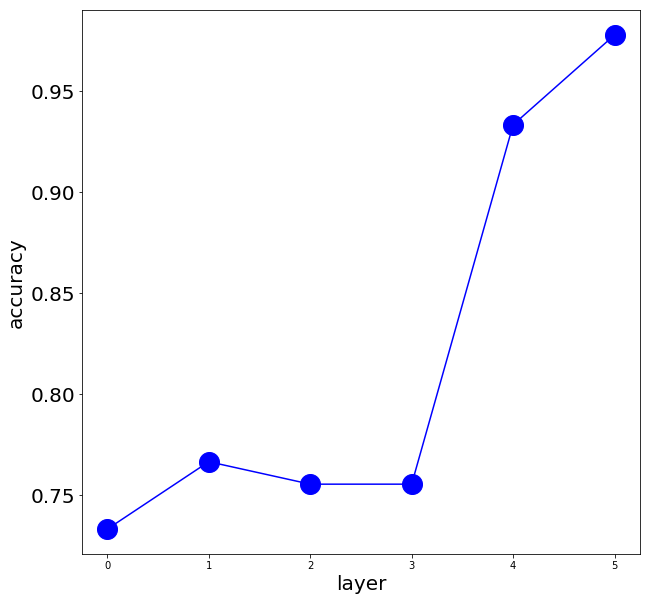

In [23]:
fs = 20
ms = 20

fig = plt.figure(figsize=(10,10))
plt.plot(range(len(layer_outs)), Score, '-bo',markersize=ms) 
#plt.xticks(range(len(layer_outs)), 
#           layers_labels, 
#           rotation='vertical',
#           fontsize=fs)

plt.yticks(fontsize=fs)
plt.ylabel('accuracy',fontsize=fs)
plt.xlabel('layer',fontsize=fs)
plt.show()

# CIFAR-10


https://github.com/geifmany/cifar-vgg



Selezione layers

Cancellare cose

memoria


Immagini cifar 10






In [24]:
import keras
from keras import backend as K
from keras.datasets import cifar10
from cifar10vgg import cifar10vgg

In [25]:

def load_cifar10_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_test_int = y_test
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)    
    return x_train, x_test, y_train, y_test, y_test_int

In [26]:
x_train, x_test, y_train, y_test, y_test_int = load_cifar10_data()

In [27]:
model = cifar10vgg(train=False)
#model_untrained = cifar10vgg(train=True)

In [28]:
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
__________

In [29]:
n_samples = 30
samples = x_test[:n_samples,:,:,:]
labels  = y_test[:n_samples,:]
labels_int = y_test_int[:n_samples]
print(samples.shape)
print(labels.shape)

(30, 32, 32, 3)
(30, 10)


In [30]:
from time import time
tin = time()
predicted_x = model.predict(samples)
print('Elapsed : {}'.format(time() - tin))

Elapsed : 1.864112377166748


In [31]:
residuals = np.argmax(predicted_x,1) != np.argmax(labels,1)
loss = sum(residuals)/len(residuals)
print("the validation 0/1 loss is: ",loss)

the validation 0/1 loss is:  0.0


In [32]:
np.argmax(predicted_x[:10],1)

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [33]:
np.argmax(labels[:10],1)

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [34]:
layers_outs = extract_representations(model.model)

In [35]:
layers_names = [l.name for l in model.model.layers]

In [36]:
_ = [print(i, name, l.shape) for i, (name, l) in enumerate(zip(layers_names, layers_outs) )]

0 conv2d_1 (30, 32, 32, 64)
1 activation_1 (30, 32, 32, 64)
2 batch_normalization_1 (30, 32, 32, 64)
3 dropout_1 (30, 32, 32, 64)
4 conv2d_2 (30, 32, 32, 64)
5 activation_2 (30, 32, 32, 64)
6 batch_normalization_2 (30, 32, 32, 64)
7 max_pooling2d_1 (30, 16, 16, 64)
8 conv2d_3 (30, 16, 16, 128)
9 activation_3 (30, 16, 16, 128)
10 batch_normalization_3 (30, 16, 16, 128)
11 dropout_2 (30, 16, 16, 128)
12 conv2d_4 (30, 16, 16, 128)
13 activation_4 (30, 16, 16, 128)
14 batch_normalization_4 (30, 16, 16, 128)
15 max_pooling2d_2 (30, 8, 8, 128)
16 conv2d_5 (30, 8, 8, 256)
17 activation_5 (30, 8, 8, 256)
18 batch_normalization_5 (30, 8, 8, 256)
19 dropout_3 (30, 8, 8, 256)
20 conv2d_6 (30, 8, 8, 256)
21 activation_6 (30, 8, 8, 256)
22 batch_normalization_6 (30, 8, 8, 256)
23 dropout_4 (30, 8, 8, 256)
24 conv2d_7 (30, 8, 8, 256)
25 activation_7 (30, 8, 8, 256)
26 batch_normalization_7 (30, 8, 8, 256)
27 max_pooling2d_3 (30, 4, 4, 256)
28 conv2d_8 (30, 4, 4, 512)
29 activation_8 (30, 4, 4, 512)


In [37]:
# patiently individuate dropout and pooling layers indexes 
idx = [3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 52, 57, 59]
selected_outs = [(layers_names[i],layers_outs[i]) for i in idx]
# or use a nice list comprehension
selected_outs = [(layers_names[i],layers_outs[i]) for i in range(len(layers_names)) 
                 if 'dropout' in layers_names[i] or 'pool' in layers_names[i]]

selected_layers_labels = [l for (l,_) in selected_outs]

In [39]:
#selected_layers_labels

In [41]:
Score = []
Results = []
Parameters = []


Cs = np.power(10., np.arange(-3,3))
#Cs = [0.01]

# define grid of parameters
param_grid = {'C' : Cs}
nresampling = 10
nfolds = 2
nprocs = 1


y = labels_int.ravel()

for (name, representation) in tqdm(selected_outs):
    
    X = np.reshape(representation, (n_samples, -1))
    
    # preprocessing
    #X = preprocessing.scale(X) 
    
    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.1, random_state=None)
    
    clf_ = SVC(kernel='linear')
    
    grid_search = GridSearchCV(clf_, param_grid, 
                                scoring=my_func, 
                                cv=nfolds, 
                                n_jobs=nprocs, 
                                refit=True,
                                return_train_score=True)

    grid_search.fit(X_train, y_train)    
    
    
    Score.append(grid_search.best_score_)             
    Results.append(grid_search.cv_results_)
    Parameters.append(grid_search.best_params_['C'])

  0%|          | 0/15 [00:00<?, ?it/s]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
  7%|▋         | 1/15 [00:01<00:24,  1.76s/it]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/home/qsb/.local/lib/python3.6/site-packages/sklearn

 93%|█████████▎| 14/15 [00:09<00:00,  1.83it/s]/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
/home/qsb/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
100%|██████████| 15/15 [00:09<00:00,  2.35it/s]


# Neural Data

https://github.com/dicarlolab/Cadieu_etal_PLoSCB_2014


https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003963



The experiment

<img src="figs/dicarlo_stim.png" alt="drawing" width="600" >

ten categories
